In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv

import boulderopal as bo
bo.cloud.set_organization("bik194812-gmail")
plt.style.use(qv.get_qctrl_style())

colors = {
    "Primitive": "black",
    "Optimized": qv.QCTRL_STYLE_COLORS[0],
    "Robust": qv.QCTRL_STYLE_COLORS[1],
}

Boulder Opal client update available.
Latest version is 1.1.1, you have 1.1.0.
Visit https://docs.q-ctrl.com/boulder-opal/changelog for the latest product updates.


In [2]:
###Qubit Dimension, we start with 2
dim=3

a = np.diag(np.sqrt(np.arange(1, dim)), 1) #single annhilation op
ad = a.T

a0 = np.kron(a,np.eye(dim,dtype=complex))
ad0 = np.kron(ad,np.eye(dim,dtype=complex))
a1 = np.kron(np.eye(dim,dtype=complex),a)
ad1 = np.kron(np.eye(dim,dtype=complex),ad)

In [3]:
X=np.eye(dim,dtype=complex)
Y=np.eye(dim,dtype=complex)
X[:2,:2] = np.array([[0,1],[1,0]])
Y[:2,:2] = np.array([[0,-1j],[1j,0]])

X0=np.kron(X,np.eye(dim,dtype=complex))
Y0=np.kron(Y,np.eye(dim,dtype=complex))
X1=np.kron(np.eye(dim,dtype=complex),X)
Y1=np.kron(np.eye(dim,dtype=complex),Y)

from scipy.linalg import expm

def excitation(theta):
    return expm(1j * theta/2 * (X0@ Y1 - Y0 @ X1))

In [4]:
drive_max = 200 * 2 * np.pi * 1e6  # Hz
duration = 0.4e-6  # s

In [5]:
def scheme_optimization(segment_count,target,initial):
    graph = bo.Graph()
    
    drive0x = graph.real_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            minimum=-drive_max,
            initial_values=initial["drive0x"],
            name="drive0x",
        )
    
    drive0y = graph.real_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            minimum=-drive_max,
            initial_values=initial["drive0y"],
            name="drive0y",
        )
    
    
    drive1x  = graph.real_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            minimum=-drive_max,
            initial_values=initial["drive1x"],
            name="drive1x",
        )
    
    
    drive1y  = graph.real_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            minimum=-drive_max,
            initial_values=initial["drive1y"],
            name="drive1y",
        )
    
    
    delta0 = graph.real_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            minimum=-drive_max,
            initial_values=initial["delta0"],
            name="delta0",
        )
    
        
    delta1 = graph.real_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            minimum=-drive_max,
            initial_values=initial["delta1"],
            name="delta1",
        )
    
    J = graph.real_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            minimum=-drive_max,
            initial_values=initial["J"],
            name="J",
        )

    control_hamiltonian = (
        delta0 * (ad0 @ a0) + 
        delta1 * (ad1 @ a1) +
        drive0x * (a0+ad0) +
        drive0y * 1j * (a0-ad0) +
        drive1x * (a1+ad1) +
        drive1y * 1j * (a1-ad1) +
        J * (ad0 @a1 +a0 @ ad1)
    )
    
    infidelity = graph.infidelity_pwc(
        hamiltonian=control_hamiltonian,
        target=graph.target(operator=target),
        name="infidelity",
    )
    
    return bo.run_optimization(
        graph=graph,
        optimization_count=1,
        cost_node_name="infidelity",
        output_node_names=[
            "infidelity",
            "delta0",
            "delta1",
            "drive0x",
            "drive0y",
            "drive1x",
            "drive1y",
            "J"
        ],
    )

In [6]:
pulse_names = ["delta0","delta1","drive0x","drive0y","drive1x","drive1y","J"]

In [7]:
def interpolate(theta,x,coefficients):
    data = {}
    for i in pulse_names:
        data[i]=scipy.interpolate.interp1d(x=x,y=np.array([p[i] for p in coefficients]),axis=0)(theta)
    return data


In [8]:
initializations = []
fidelities=[]
for theta in np.linspace(0,2*np.pi,20):
    if(theta==0):
        initial = {i:None for i in pulse_names}
    else:
        initial=initializations[-1]
    optimization=scheme_optimization(20,excitation(theta),initial)
    d={i:optimization['output'][i]['values'] for i in optimization['output']if('values' in optimization['output'][i])}
    fidelities.append(optimization['cost'])
    initializations.append(d)

Your task (action_id="1862685") is queued.
Your task (action_id="1862685") has completed.
Your task (action_id="1862686") has completed.
Your task (action_id="1862687") has completed.
Your task (action_id="1862688") has completed.
Your task (action_id="1862689") has started.
Your task (action_id="1862689") has completed.
Your task (action_id="1862690") has completed.
Your task (action_id="1862691") has completed.
Your task (action_id="1862692") has completed.
Your task (action_id="1862693") has completed.
Your task (action_id="1862694") has completed.
Your task (action_id="1862695") has completed.
Your task (action_id="1862696") has completed.
Your task (action_id="1862697") has completed.
Your task (action_id="1862698") has completed.
Your task (action_id="1862699") is queued.
Your task (action_id="1862699") has started.
Your task (action_id="1862699") has completed.
Your task (action_id="1862700") has completed.
Your task (action_id="1862701") is queued.
Your task (action_id="1862701

In [9]:
def simulate(data,target):
    graph = bo.Graph()
    
    drive0x = graph.pwc_signal(
            data['drive0x'], duration, name='drive0x'
        )
    
    drive0y = graph.pwc_signal(
            data['drive0y'], duration, name='drive0y'
        )
    
    
    drive1x = graph.pwc_signal(
            data['drive1x'], duration, name='drive1x'
        )
    
    
    drive1y = graph.pwc_signal(
            data['drive1y'], duration, name='drive1y'
        )
    
    
    delta0 = graph.pwc_signal(
            data['delta0'], duration, name='delta0'
        )
    
        
    delta1 = graph.pwc_signal(
            data['delta1'], duration, name='delta1'
        )
    
    J  = graph.pwc_signal(
            data['J'], duration, name='J'
        )
    
    control_hamiltonian = (
        delta0 * (ad0 @ a0) + 
        delta1 * (ad1 @ a1) +
        drive0x * (a0+ad0) +
        drive0y * 1j * (a0-ad0) +
        drive1x * (a1+ad1) +
        drive1y * 1j * (a1-ad1) +
        J * (ad0 @a1 +a0 @ ad1)
    )
    
    infidelity = graph.infidelity_pwc(
        hamiltonian=control_hamiltonian,
        target=graph.target(operator=target),
        name="infidelity",
    )
    
    graph_result = bo.execute_graph(graph = graph, output_node_names = ["infidelity"])
    return graph_result

In [10]:
fidelities=[]
import scipy
for theta in np.linspace(0,2*np.pi,100):
    initial=interpolate(theta,np.linspace(0,2*np.pi,20),initializations)
    simulation=simulate(initial,excitation(theta))
    fidelities.append(simulation['output']['infidelity']['value'])


Your task (action_id="1862705") has completed.
Your task (action_id="1862706") has completed.
Your task (action_id="1862707") has started.
Your task (action_id="1862707") has completed.
Your task (action_id="1862708") has completed.
Your task (action_id="1862709") has completed.
Your task (action_id="1862710") is queued.
Your task (action_id="1862710") has completed.
Your task (action_id="1862711") has completed.
Your task (action_id="1862712") has started.
Your task (action_id="1862712") has completed.
Your task (action_id="1862713") has completed.
Your task (action_id="1862714") has completed.
Your task (action_id="1862715") is queued.
Your task (action_id="1862715") has completed.
Your task (action_id="1862716") has completed.
Your task (action_id="1862717") has completed.
Your task (action_id="1862718") has completed.
Your task (action_id="1862719") has completed.
Your task (action_id="1862720") is queued.
Your task (action_id="1862720") has completed.
Your task (action_id="1862721

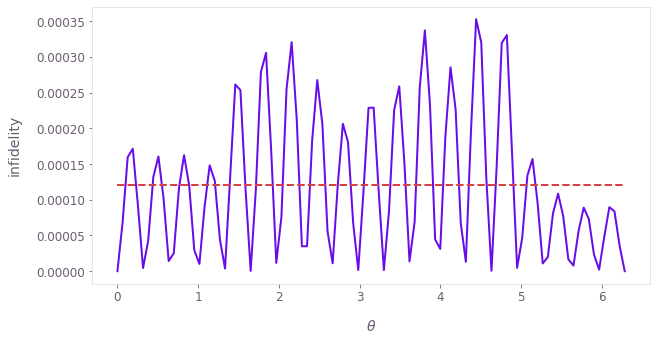

In [18]:
plt.plot(np.linspace(0,2*np.pi,100),fidelities)
plt.xlabel("$\\theta$")
plt.ylabel("infidelity")
plt.xlabel("$\\theta$")
plt.ylabel("infidelity")
plt.plot(np.linspace(0,2*np.pi,100),[np.mean(fidelities)]*len(np.linspace(0,2*np.pi,100)),'--')
plt.title("Infidelity Plot (Interpolation)")

In [12]:
thetac = max(np.linspace(0,2*np.pi,100), key = lambda v : fidelities[list(np.linspace(0,2*np.pi,100)).index(v)])
print("Problem Angle: "+str(thetac))

Problem Angle: 4.442656277803748


In [13]:
new_coefficients = []
new_fidelities = []
problem_thetas = [thetac]
for _ in range(10):
    print("------------")
    print("Iteration: "+str(_))
    print("------------")
    new_coefficients = []
    new_fidelities = []
    theta_list = list(np.linspace(0,2*np.pi,20))+problem_thetas
    theta_list.sort()
    for theta in theta_list:
        if(theta==0):
            initial = initial = {i:None for i in pulse_names}
        else:
            initial = new_coefficients[len(new_coefficients)-1]
        optimization=scheme_optimization(20,excitation(theta),initial)
        d={i:optimization['output'][i]['values'] for i in optimization['output']if('values' in optimization['output'][i])}
        new_coefficients.append(d)
            
    for theta in np.linspace(0,2*np.pi,100):
        initial=interpolate(theta,theta_list,new_coefficients)
        simulation=simulate(initial,excitation(theta))
        new_fidelities.append(simulation['output']['infidelity']['value'])
    thetac = max(np.linspace(0,2*np.pi,100), key = lambda v : new_fidelities[list(np.linspace(0,2*np.pi,100)).index(v)])
    print("Problem Angle: "+str(thetac))
    problem_thetas.append(thetac)

------------
Iteration: 0
------------
Your task (action_id="1862805") is queued.
Your task (action_id="1862805") has completed.
Your task (action_id="1862806") has completed.
Your task (action_id="1862807") has completed.
Your task (action_id="1862808") has completed.
Your task (action_id="1862809") has started.
Your task (action_id="1862809") has completed.
Your task (action_id="1862810") has completed.
Your task (action_id="1862811") is queued.
Your task (action_id="1862811") has completed.
Your task (action_id="1862812") has completed.
Your task (action_id="1862813") has completed.
Your task (action_id="1862814") has completed.
Your task (action_id="1862815") is queued.
Your task (action_id="1862815") has started.
Your task (action_id="1862815") has completed.
Your task (action_id="1862816") has completed.
Your task (action_id="1862817") has completed.
Your task (action_id="1862818") has completed.
Your task (action_id="1862819") is queued.
Your task (action_id="1862819") has compl

Your task (action_id="1862949") has completed.
Your task (action_id="1862950") is queued.
Your task (action_id="1862950") has completed.
Your task (action_id="1862951") has completed.
Your task (action_id="1862952") has started.
Your task (action_id="1862952") has completed.
Your task (action_id="1862953") has completed.
Your task (action_id="1862954") has completed.
Your task (action_id="1862955") has completed.
Your task (action_id="1862956") has completed.
Your task (action_id="1862957") has completed.
Your task (action_id="1862958") has completed.
Your task (action_id="1862959") has started.
Your task (action_id="1862959") has completed.
Your task (action_id="1862960") has completed.
Your task (action_id="1862961") has completed.
Your task (action_id="1862962") has completed.
Your task (action_id="1862963") has completed.
Your task (action_id="1862964") has started.
Your task (action_id="1862964") has completed.
Your task (action_id="1862965") has completed.
Your task (action_id="1

Your task (action_id="1863098") has started.
Your task (action_id="1863098") has completed.
Your task (action_id="1863104") has completed.
Your task (action_id="1863105") has completed.
Your task (action_id="1863106") has completed.
Your task (action_id="1863107") has completed.
Your task (action_id="1863108") has started.
Your task (action_id="1863108") has completed.
Your task (action_id="1863109") has completed.
Your task (action_id="1863110") has completed.
Your task (action_id="1863111") is queued.
Your task (action_id="1863111") has completed.
Your task (action_id="1863112") has completed.
Your task (action_id="1863113") has started.
Your task (action_id="1863113") has completed.
Your task (action_id="1863114") has completed.
Your task (action_id="1863115") has completed.
Your task (action_id="1863116") is queued.
Your task (action_id="1863116") has completed.
Your task (action_id="1863117") has completed.
Your task (action_id="1863118") has started.
Your task (action_id="1863118

Your task (action_id="1863232") has started.
Your task (action_id="1863232") has completed.
Your task (action_id="1863233") has completed.
Your task (action_id="1863234") has completed.
Your task (action_id="1863235") has completed.
Your task (action_id="1863236") has completed.
Your task (action_id="1863237") has started.
Your task (action_id="1863237") has completed.
Your task (action_id="1863238") has completed.
Your task (action_id="1863239") has completed.
Your task (action_id="1863240") is queued.
Your task (action_id="1863240") has completed.
Your task (action_id="1863241") has completed.
Your task (action_id="1863242") has started.
Your task (action_id="1863242") has completed.
Your task (action_id="1863243") has completed.
Your task (action_id="1863244") has completed.
Your task (action_id="1863245") is queued.
Your task (action_id="1863245") has completed.
Your task (action_id="1863246") has completed.
Your task (action_id="1863247") has started.
Your task (action_id="1863247

Your task (action_id="1863366") has started.
Your task (action_id="1863366") has completed.
Your task (action_id="1863367") has completed.
Your task (action_id="1863368") has completed.
Your task (action_id="1863369") has completed.
Your task (action_id="1863370") has completed.
Your task (action_id="1863371") has started.
Your task (action_id="1863371") has completed.
Your task (action_id="1863372") has completed.
Your task (action_id="1863373") has completed.
Your task (action_id="1863374") has completed.
Your task (action_id="1863375") has completed.
Your task (action_id="1863376") has started.
Your task (action_id="1863376") has completed.
Your task (action_id="1863377") has completed.
Your task (action_id="1863378") has completed.
Your task (action_id="1863379") has completed.
Your task (action_id="1863380") has completed.
Your task (action_id="1863381") has started.
Your task (action_id="1863381") has completed.
Your task (action_id="1863382") has completed.
Your task (action_id=

Your task (action_id="1863515") has completed.
Your task (action_id="1863516") has completed.
Your task (action_id="1863517") has started.
Your task (action_id="1863517") has completed.
Your task (action_id="1863518") has completed.
Your task (action_id="1863519") has completed.
Your task (action_id="1863520") has completed.
Your task (action_id="1863521") has completed.
Your task (action_id="1863522") has started.
Your task (action_id="1863522") has completed.
Your task (action_id="1863523") has completed.
Your task (action_id="1863524") has completed.
Your task (action_id="1863525") has completed.
Your task (action_id="1863526") has completed.
Your task (action_id="1863527") has started.
Your task (action_id="1863527") has completed.
Your task (action_id="1863528") has completed.
Your task (action_id="1863529") has completed.
Your task (action_id="1863530") has completed.
Your task (action_id="1863531") has completed.
Your task (action_id="1863532") has started.
Your task (action_id=

Your task (action_id="1863649") has completed.
Your task (action_id="1863650") has started.
Your task (action_id="1863650") has completed.
Your task (action_id="1863651") has completed.
Your task (action_id="1863652") has completed.
Your task (action_id="1863653") has started.
Your task (action_id="1863653") has completed.
Your task (action_id="1863654") has completed.
Your task (action_id="1863655") has started.
Your task (action_id="1863655") has completed.
Your task (action_id="1863656") has completed.
Your task (action_id="1863657") has completed.
Your task (action_id="1863658") has completed.
Your task (action_id="1863659") has completed.
Your task (action_id="1863660") has started.
Your task (action_id="1863660") has completed.
Your task (action_id="1863661") has completed.
Your task (action_id="1863662") has completed.
Your task (action_id="1863663") has completed.
Your task (action_id="1863664") has completed.
Your task (action_id="1863665") has completed.
Your task (action_id=

Your task (action_id="1863789") has completed.
Your task (action_id="1863790") has completed.
Your task (action_id="1863791") has completed.
Your task (action_id="1863792") has completed.
Your task (action_id="1863793") has started.
Your task (action_id="1863793") has completed.
Your task (action_id="1863794") has completed.
Your task (action_id="1863795") has completed.
Your task (action_id="1863796") has completed.
Your task (action_id="1863797") has completed.
Your task (action_id="1863798") has started.
Your task (action_id="1863798") has completed.
Your task (action_id="1863799") has completed.
Your task (action_id="1863800") has completed.
Your task (action_id="1863801") is queued.
Your task (action_id="1863801") has completed.
Your task (action_id="1863802") has completed.
Your task (action_id="1863803") has started.
Your task (action_id="1863803") has completed.
Your task (action_id="1863804") has completed.
Your task (action_id="1863805") has completed.
Your task (action_id="1

Your task (action_id="1863931") has completed.
Your task (action_id="1863932") has completed.
Your task (action_id="1863933") has completed.
Your task (action_id="1863934") has completed.
Your task (action_id="1863935") has completed.
Your task (action_id="1863936") has started.
Your task (action_id="1863936") has completed.
Your task (action_id="1863937") has completed.
Your task (action_id="1863938") has completed.
Your task (action_id="1863939") has completed.
Your task (action_id="1863940") has completed.
Your task (action_id="1863941") has started.
Your task (action_id="1863941") has completed.
Your task (action_id="1863942") has completed.
Your task (action_id="1863943") has completed.
Your task (action_id="1863944") has completed.
Problem Angle: 2.475194211919231
------------
Iteration: 9
------------
Your task (action_id="1863945") has completed.
Your task (action_id="1863946") has started.
Your task (action_id="1863946") has completed.
Your task (action_id="1863947") has compl

Your task (action_id="1864074") has completed.
Problem Angle: 0.1903995547630178


Text(0.5, 1.0, 'Infidelity Plot (Re-optimization)')

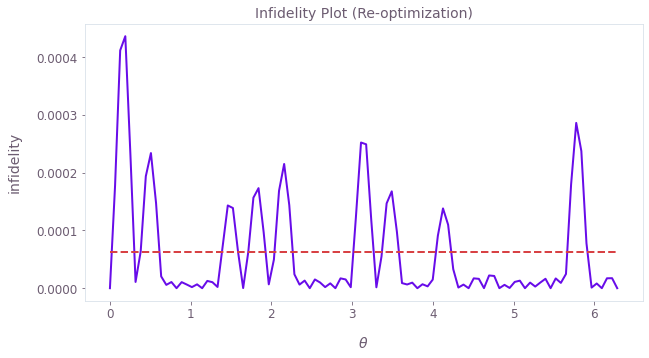

In [19]:
plt.plot(np.linspace(0,2*np.pi,100),new_fidelities)
plt.xlabel("$\\theta$")
plt.ylabel("infidelity")
plt.plot(np.linspace(0,2*np.pi,100),[np.mean(new_fidelities)]*len(np.linspace(0,2*np.pi,100)),'--')
plt.title("Infidelity Plot (Re-optimization)")